In [5]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath

def mask_composite(ds, var, start_year=0, min_lat=-90, max_lat=90, min_lon=0, max_lon=360):
    X = np.meshgrid(ds.x.data,ds.y.data)
    mask = xr.DataArray(np.sqrt(X[0]**2 + X[1]**2) <= 10, dims=['x', 'y'])
    
    idx_region = (ds.snap_time.dt.hour == 12) & (ds.snap_time.dt.year > start_year) & (ds.snap_lat >= min_lat) & (ds.snap_lat <= max_lat) & \
    (ds.snap_lon >= min_lon) & (ds.snap_lon <= max_lon)
    
    test = ds[f"snap_{var}"][idx_region,:,:]
    test = xr.where(abs(test)>1e10, np.nan, test)
    test = xr.where(test==0, np.nan, test)
    
    time = ds.snap_time[idx_region]

    out_masked = xr.where(mask, test, np.nan)
    return out_masked, time

In [8]:
ds_dic = xr.open_dataset("/work/Katherine.Turner/tempest-extremes/CM4_daily_rerun/comp_DIC_anom.nc", use_cftime=True)
ds_sst = xr.open_dataset("/work/Katherine.Turner/tempest-extremes/odiv-251/comp_tos/comp_tos_anom.nc", use_cftime=True)
ds_mld = xr.open_dataset("/work/Katherine.Turner/tempest-extremes/odiv-251/comp_MLD/comp_MLD_003_anom.nc", use_cftime=True)

In [58]:
comp_dic, time_dic = mask_composite(ds_dic, "DIC_anom")
comp_dic_monthly = comp_dic.groupby(time_dic.dt.season).mean()

comp_sst, time_sst = mask_composite(ds_sst, "tos_anom")
comp_sst_monthly = comp_sst.groupby(time_sst.dt.season).mean()

comp_mld, time_mld = mask_composite(ds_mld, "MLD_003_anom")
comp_mld_monthly = comp_mld.groupby(time_mld.dt.season).mean()

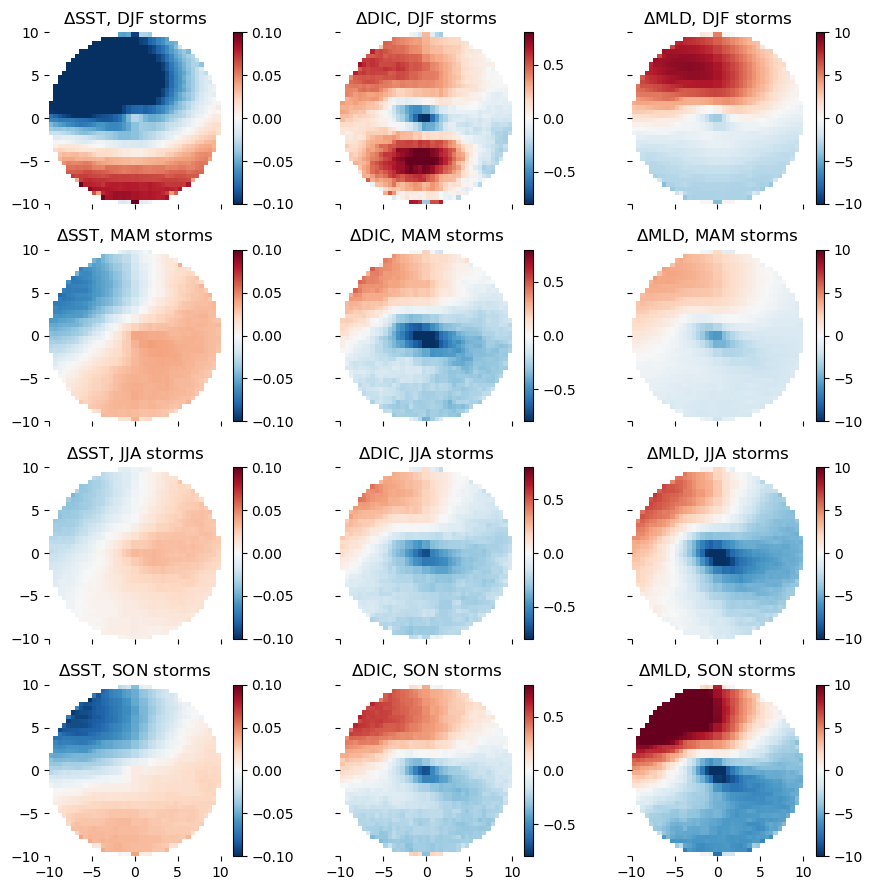

In [69]:
comp_dic_monthly.season

varname = ["SST", "DIC", "MLD"]
mon = ["DJF", "MAM", "JJA", "SON"]

fig, axs = plt.subplots(figsize=(9,9), ncols=3, nrows=4, sharex=True, sharey=True)
axs=axs.flatten()

for i in np.arange(3):
    
    v = varname[i]
    
    for j, s_name in enumerate(mon):
    
        if v == "SST":
            comp_sst_monthly.sel(season=s_name).plot(ax=axs[i+3*j], y='y', vmin=-.1, vmax=.1, cmap="RdBu_r", extend="neither")
            axs[i+3*j].set_title("$\Delta$"+v+f", {mon[j]} storms")
        elif v == "DIC":
            (comp_dic_monthly*1e6/1024.5).sel(season=s_name).plot(ax=axs[i+3*j], y='y', vmin = -.8, vmax=0.8, cmap="RdBu_r", extend="neither")
            axs[i+3*j].set_title("$\Delta$"+v+f", {mon[j]} storms")
        elif v == "MLD":
            comp_mld_monthly.sel(season=s_name).plot(ax=axs[i+3*j], y='y', vmin=-10, vmax=10, cmap="RdBu_r", extend="neither")
            axs[i+3*j].set_title("$\Delta$"+v+f", {mon[j]} storms")

for i in np.arange(12):
    axs[i].set_box_aspect(1)
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].set_frame_on(False)

plt.tight_layout()
plt.savefig(f"/home/Katherine.Turner/Figures/tempest-extremes/surface_vars_seasonal_comps.png", format="png", dpi=100)

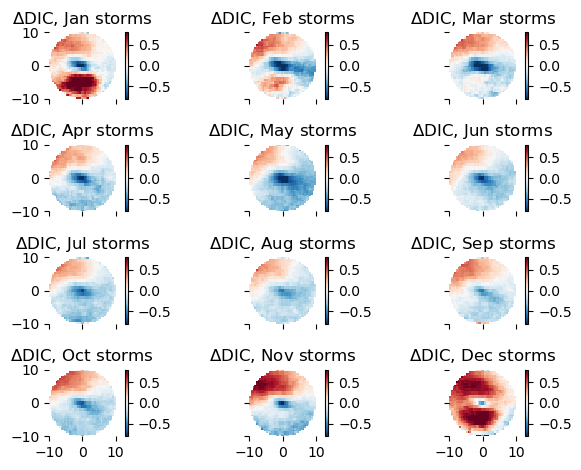

In [10]:
v = "DIC"
mon = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

fig, axs = plt.subplots(ncols=3, nrows=4, sharex=True, sharey=True)
axs=axs.flatten()

for i in np.arange(12):
    
    if v == "SST":
        (comp_sst_monthly[:,:,i]).plot(ax=axs[i], y='y', vmin=-.1, vmax=.1, cmap="RdBu_r", extend="neither")
    elif v == "DIC":
        (comp_dic_monthly[:,:,i]*1e6/1024.5).plot(ax=axs[i], y='y', vmin = -.8, vmax=0.8, cmap="RdBu_r", extend="neither")
    elif v == "MLD":
        (comp_mld_monthly[:,:,i]).plot(ax=axs[i], y='y', vmin=-10, vmax=10, cmap="RdBu_r", extend="neither")

for i in np.arange(12):
    axs[i].set_box_aspect(1)
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    t = "$\Delta$"+v+f", {mon[i]} storms"
    axs[i].set_title(t)
    #axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].set_frame_on(False)

plt.tight_layout()
#plt.savefig(f"/home/Katherine.Turner/Figures/tempest-extremes/surface_{v}_comps.png", format="png", dpi=100)

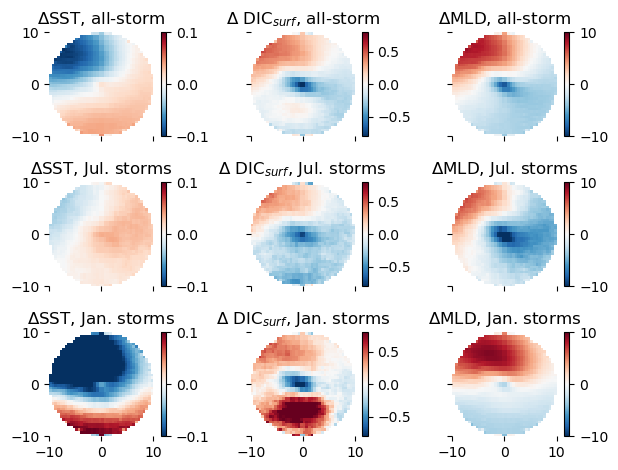

In [7]:
titles = ["$\Delta$SST, all-storm", "$\Delta$ DIC$_{surf}$, all-storm", "$\Delta$MLD, all-storm", \
          "$\Delta$SST, Jul. storms", "$\Delta$ DIC$_{surf}$, Jul. storms", "$\Delta$MLD, Jul. storms", \
          "$\Delta$SST, Jan. storms", "$\Delta$ DIC$_{surf}$, Jan. storms", "$\Delta$MLD, Jan. storms"]

fig, axs = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True)
axs=axs.flatten()

(comp_sst).mean(dim='snapshot').plot(ax=axs[0], y='y', vmin=-.1, vmax=.1, cmap="RdBu_r", extend="neither")
(comp_sst_monthly[:,:,6]).plot(ax=axs[3], y='y', vmin=-.1, vmax=.1, cmap="RdBu_r", extend="neither")
(comp_sst_monthly[:,:,0]).plot(ax=axs[6], y='y', vmin=-.1, vmax=.1, cmap="RdBu_r", extend="neither")

(comp_dic*1e6/1024.5).mean(dim='snapshot').plot(ax=axs[1], y='y', vmin = -.8, vmax=0.8, cmap="RdBu_r", extend="neither")
(comp_dic_monthly[:,:,6]*1e6/1024.5).plot(ax=axs[4], y='y', vmin = -.8, vmax=0.8, cmap="RdBu_r", extend="neither")
(comp_dic_monthly[:,:,0]*1e6/1024.5).plot(ax=axs[7], y='y', vmin = -.8, vmax=0.8, cmap="RdBu_r", extend="neither")

(comp_mld).mean(dim='snapshot').plot(ax=axs[2], y='y', vmin=-10, vmax=10, cmap="RdBu_r", extend="neither")
(comp_mld_monthly[:,:,6]).plot(ax=axs[5], y='y', vmin=-10, vmax=10, cmap="RdBu_r", extend="neither")
(comp_mld_monthly[:,:,0]).plot(ax=axs[8], y='y', vmin=-10, vmax=10, cmap="RdBu_r", extend="neither")

for i in np.arange(9):
    axs[i].set_box_aspect(1)
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].set_title(titles[i])
    #axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].set_frame_on(False)

plt.tight_layout()
#plt.savefig("/home/Katherine.Turner/Figures/tempest-extremes/surface_comps.png", format="png", dpi=100)

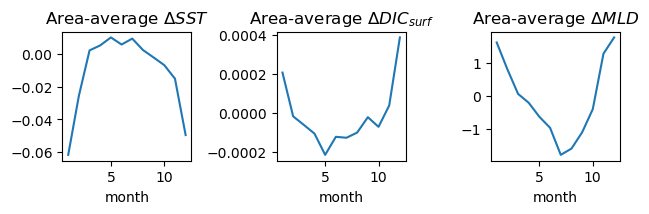

In [5]:
titles = ["Area-average $\Delta SST$", "Area-average $\Delta DIC_{surf}$", "Area-average $\Delta MLD$"]

fig, axs = plt.subplots(ncols=3, nrows=1)
comp_sst_monthly.mean(dim={'x','y'}).plot(ax=axs[0])
comp_dic_monthly.mean(dim={'x','y'}).plot(ax=axs[1])
comp_mld_monthly.mean(dim={'x','y'}).plot(ax=axs[2])

for i in np.arange(3):
    axs[i].set_box_aspect(1)
    axs[i].set_title(titles[i])
plt.tight_layout()
plt.savefig("/home/Katherine.Turner/Figures/tempest-extremes/surface_comps_area_avg.png", format="png", dpi=100)

In [71]:
def mask_composite_static(ds, var, start_year=0, min_lat=-90, max_lat=90, min_lon=0, max_lon=360):
    X = np.meshgrid(ds.x.data,ds.y.data)
    mask = xr.DataArray(np.sqrt(X[0]**2 + X[1]**2) <= 10, dims=['x', 'y'])
    
    idx_region = (ds.snap_time.dt.year > start_year) & (ds.snap_lat >= min_lat) & (ds.snap_lat <= max_lat) & \
    (ds.snap_lon >= min_lon) & (ds.snap_lon <= max_lon)
    
    test = ds[f"snap_{var}"][idx_region,:,:]
    test = xr.where(abs(test)>1e10, np.nan, test)
    test = xr.where(test==0, np.nan, test)

    out_masked = xr.where(mask, test, np.nan)
    return out_masked

In [72]:
ds_dic_static = xr.open_dataset("/work/Katherine.Turner/tempest-extremes/CM4_daily_rerun/comp_DIC_anom_static.nc", use_cftime=True)
comp_dic_static = mask_composite_static(ds_dic_static, "DIC_anom")

ds_tos_static = xr.open_dataset("/work/Katherine.Turner/tempest-extremes/odiv-251/comp_tos/comp_tos_anom_static.nc", use_cftime=True)
comp_tos_static = mask_composite_static(ds_tos_static, "tos_anom")

ds_mld_static = xr.open_dataset("/work/Katherine.Turner/tempest-extremes/odiv-251/comp_omldamax_regrid/impulse_comp_omldamax_anom.nc", use_cftime=True)
comp_mld_static = mask_composite_static(ds_mld_static, "omldamax_anom")

In [29]:
idx_May2 = (ds_dic_static.snap_time.dt.month == 5) & (np.arange(514800)%11 == 2)
idx_May10 = (ds_dic_static.snap_time.dt.month == 5) & (np.arange(514800)%11 == 10)

idx_Nov2 = (ds_dic_static.snap_time.dt.month == 11) & (np.arange(514800)%11 == 2)
idx_Nov10 = (ds_dic_static.snap_time.dt.month == 11) & (np.arange(514800)%11 == 10)

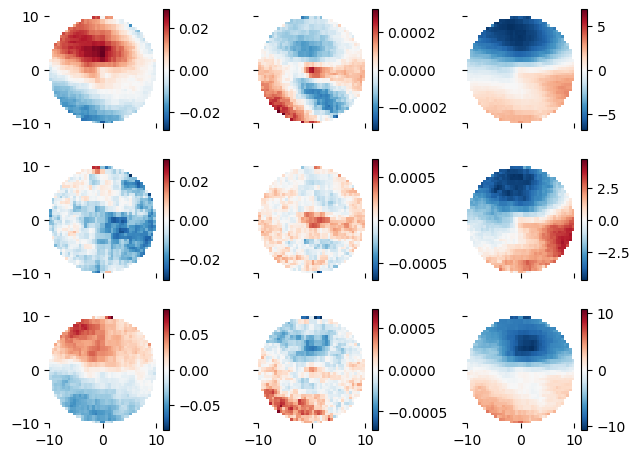

In [31]:
fig, axs = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True)
axs=axs.flatten()

(comp_tos_static[:,:,10::11].mean(dim="snapshot") - comp_tos_static[:,:,2::11].mean(dim="snapshot")).plot(ax=axs[0], y='y')

(comp_dic_static[:,:,10::11].mean(dim="snapshot") - comp_dic_static[:,:,2::11].mean(dim="snapshot")).plot(ax=axs[1], y='y')

(comp_mld_static[:,:,10::11].mean(dim="snapshot") - comp_mld_static[:,:,2::11].mean(dim="snapshot")).plot(ax=axs[2], y='y')

(comp_tos_static[:,:,idx_May10].mean(dim="snapshot") - comp_tos_static[:,:,idx_May2].mean(dim="snapshot")).plot(ax=axs[3], y='y')

(comp_dic_static[:,:,idx_May10].mean(dim="snapshot") - comp_dic_static[:,:,idx_May2].mean(dim="snapshot")).plot(ax=axs[4], y='y')

(comp_mld_static[:,:,idx_May10].mean(dim="snapshot") - comp_mld_static[:,:,idx_May2].mean(dim="snapshot")).plot(ax=axs[5], y='y')


(comp_tos_static[:,:,idx_Nov10].mean(dim="snapshot") - comp_tos_static[:,:,idx_Nov2].mean(dim="snapshot")).plot(ax=axs[6], y='y')

(comp_dic_static[:,:,idx_Nov10].mean(dim="snapshot") - comp_dic_static[:,:,idx_Nov2].mean(dim="snapshot")).plot(ax=axs[7], y='y')

(comp_mld_static[:,:,idx_Nov10].mean(dim="snapshot") - comp_mld_static[:,:,idx_Nov2].mean(dim="snapshot")).plot(ax=axs[8], y='y')

for i in np.arange(9):
    axs[i].set_box_aspect(1)
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    #axs[i].set_title(titles[i])
    #axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].set_frame_on(False)
plt.tight_layout()

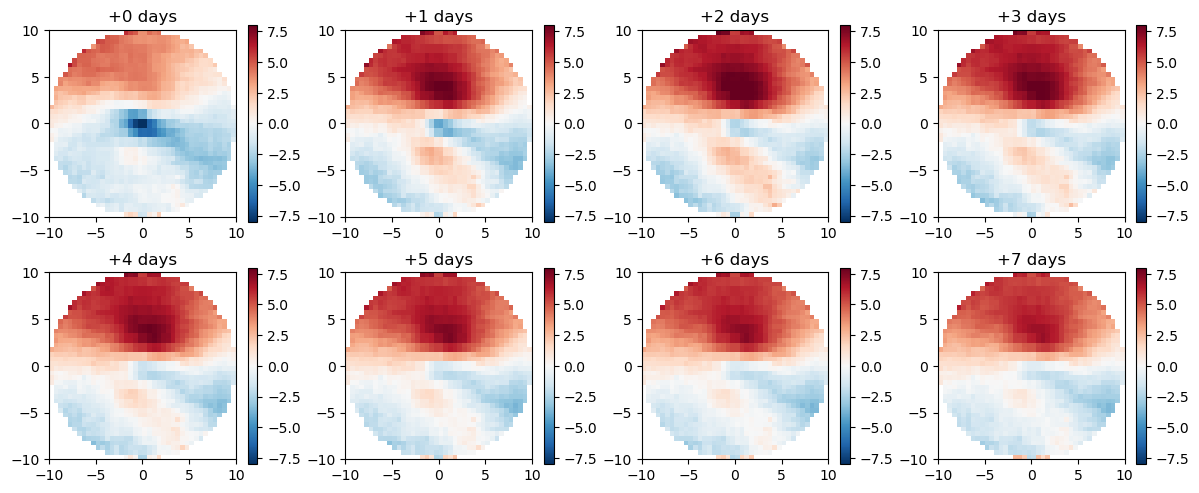

In [116]:
fig, axs = plt.subplots(figsize=(12,5), nrows=2, ncols=4)
axs = axs.flatten()

for i in np.arange(8):
    (1e4*comp_dic_static[:,:,i::11]).mean(dim="snapshot").plot(ax=axs[i], y='y', vmin=-8, vmax=8, cmap="RdBu_r", extend="neither")
    axs[i].set_title(f"+{i} days")
    axs[i].set_aspect(1)
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
plt.tight_layout()
plt.savefig("/home/Katherine.Turner/Figures/tempest-extremes/DIC_lagged_response.png", dpi=100, format="png", bbox_inches="tight")

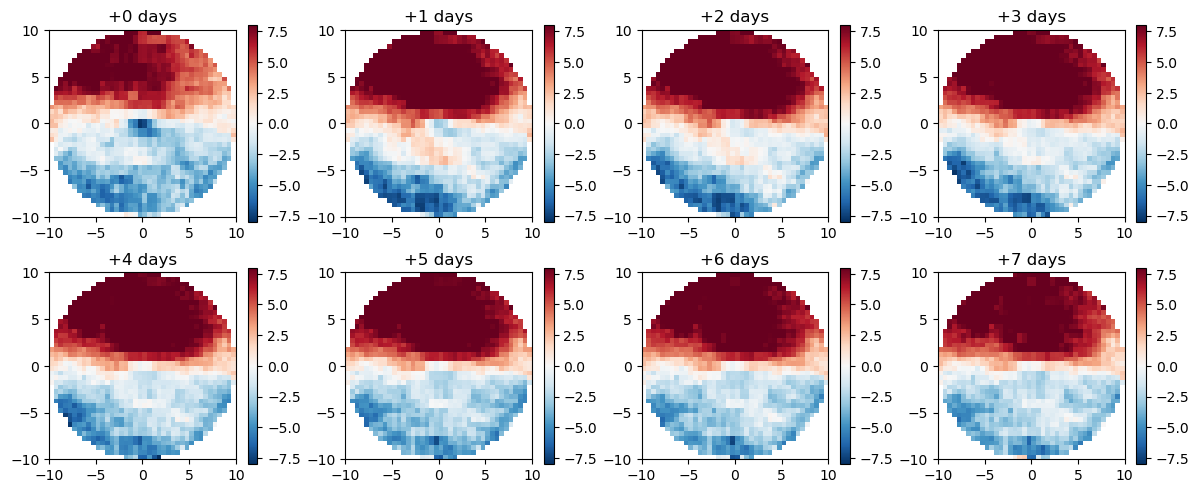

In [13]:
fig, axs = plt.subplots(figsize=(12,5), nrows=2, ncols=4)
axs = axs.flatten()

for i in np.arange(8):
    
    idx_time = (ds_static.snap_time.dt.month == 11) & (np.arange(514800)%11 == i)
    
    (1e4*comp_dic_static[:,:,idx_time]).mean(dim="snapshot").plot(ax=axs[i], y='y', vmin=-8, vmax=8, cmap="RdBu_r", extend="neither")
    axs[i].set_title(f"+{i} days")
    axs[i].set_aspect(1)
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
plt.tight_layout()
#plt.savefig("/home/Katherine.Turner/Figures/tempest-extremes/DIC_lagged_response_Nov.png", dpi=100, format="png", bbox_inches="tight")

## Looking at traits for December composites

In [46]:
idx_DEC = time_dic.dt.month == 12
idx_MAY = time_dic.dt.month == 5

In [54]:
dic_DEC = comp_dic[:,:,idx_DEC]
dic_MAY = comp_dic[:,:,idx_MAY]

n_DEC = np.size(dic_DEC,2)
n_MAY = np.size(dic_MAY,2)

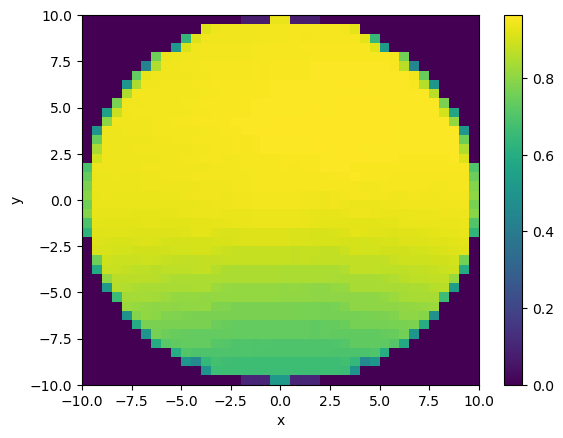

In [55]:
((dic_MAY/dic_MAY).sum("snapshot")/n_MAY).plot(y='y')

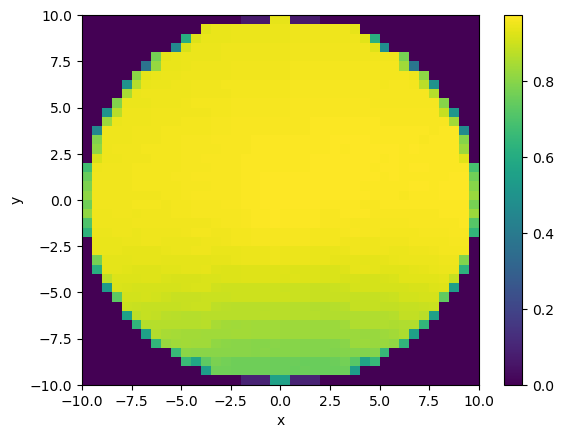

In [56]:
((dic_DEC/dic_DEC).sum("snapshot")/n_DEC).plot(y='y')

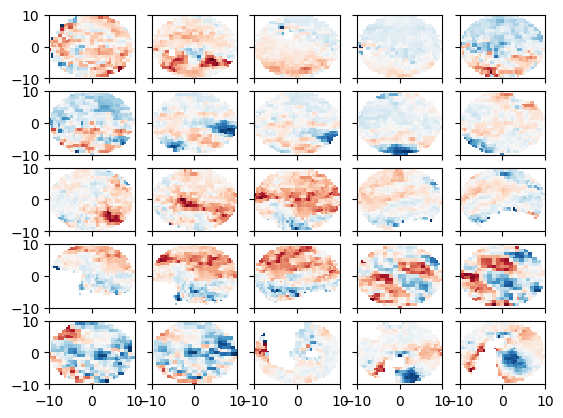

In [41]:
fig, axs = plt.subplots(ncols=5, nrows=5, sharex=True, sharey=True)
axs = axs.flatten()

for i in np.arange(25):
    dic_DEC[:,:,i+200].plot(ax=axs[i], y='y', add_colorbar=False)
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')